# Tutorial

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import hucira as hc

import warnings
from tqdm import TqdmWarning

warnings.simplefilter("ignore", TqdmWarning)

import time
start = time.time()

/lustre/groups/ml01/workspace/jenni.liu/conda_extern/envs/hucira/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The Human Cytokine Dictionary

The Human Cytokine Dictionary (hcd) can be accessed through this module. Your query data should be a transcriptomic data object in AnnData's .h5ad format with gene symbols in .var axis and metadata describing immune celltypes and experimental conditions of samples. Using the Human Cytokine Dictionary as reference, you can "look up" cytokine responses of the disease states in your own dataset.

# 1. Load input data

The two main input files for this tool are:
1. the Human Cytokine Dictionary 
2. your transcriptome data object

Explore their metadata annotation for cell types and disease condition.

In [2]:
#### Load the human cytokine dictionary

df_hcd_all = hc.load_human_cytokine_dict()

print(f"All celltypes in dictionary:\n  {df_hcd_all.celltype.unique()}")
print("\n")
print(f"All cytokines in dictionary:\n  {df_hcd_all.cytokine.unique()}")

df_hcd_all.head()

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/human_cytokine_dict.csv
All celltypes in dictionary:
  ['Intermediate_B_cell' 'NKT' 'CD8_Memory_T_cell' 'NK_CD56low' 'CD16_Mono'
 'NK_CD56hi' 'CD8_Naive_T_cell' 'pDC' 'ILC' 'MAIT' 'Naive_B_cell'
 'CD4_Naive_T_cell' 'Treg' 'Plasmablast' 'Granulocyte' 'B_cell'
 'CD4_T_cell' 'HSPC' 'CD8_T_cell' 'CD14_Mono' 'cDC' 'CD4_Memory_T_cell'
 'NK' 'Mono']


All cytokines in dictionary:
  ['4-1BBL' 'ADSF' 'APRIL' 'BAFF' 'C3a' 'C5a' 'CD27L' 'CD30L' 'CD40L' 'CT-1'
 'Decorin' 'EGF' 'EPO' 'FGF-beta' 'FLT3L' 'FasL' 'G-CSF' 'GDNF' 'GITRL'
 'GM-CSF' 'HGF' 'IFN-alpha1' 'IFN-beta' 'IFN-epsilon' 'IFN-gamma'
 'IFN-lambda1' 'IFN-lambda2' 'IFN-lambda3' 'IFN-omega' 'IGF-1'
 'IL-1-alpha' 'IL-1-beta' 'IL-10' 'IL-11' 'IL-12' 'IL-13' 'IL-15' 'IL-16'
 'IL-17A' 'IL-17B' 'IL-17C' 'IL-17D' 'IL-17E' 'IL-17F' 'IL-18' 'IL-19'
 'IL-1Ra' 'IL-2' 'IL-20' 'IL-21' 'IL-22' 'IL-23' 'IL-24' 'IL-26' 'IL-27'
 'IL-3' 'IL-31' 'IL-32-beta' 'IL-33' 'IL-34' 'IL-3

,gene,log_fc,logCPM,F,p_value,adj_p_value,contrast,celltype,cytokine,num_donors,median_num_cells_pbs,median_num_cells_cytokine,mean_num_cells_pbs,mean_num_cells_cytokine,min_num_cells_pbs,min_num_cells_cytokine,max_num_cells_pbs,max_num_cells_cytokine,num_DE_pbs_wells,well_biased
90,A1BG-AS1,-0.238704,3.888135,3.040818,0.093012,0.433379,NaN,Intermediate_B_cell,4-1BBL,12.0,1435.5,215.5,1814.333333,307.166667,367.0,60.0,4609.0,864.0,0.0,False
91,A1BG-AS1,-0.077966,3.918833,0.396225,0.535585,0.791563,NaN,Intermediate_B_cell,ADSF,12.0,1435.5,264.0,1814.333333,299.750000,367.0,53.0,4609.0,692.0,0.0,False
92,A1BG-AS1,-0.208858,3.911595,2.522081,0.124235,0.408307,NaN,Intermediate_B_cell,APRIL,12.0,1435.5,167.0,1814.333333,195.166667,367.0,55.0,4609.0,482.0,0.0,False
93,A1BG-AS1,-0.293355,3.897822,6.232523,0.019998,0.098003,NaN,Intermediate_B_cell,BAFF,12.0,1435.5,203.5,1814.333333,209.250000,367.0,74.0,4609.0,450.0,2.0,False
94,A1BG-AS1,-0.287312,3.909828,3.914004,0.058553,0.374818,NaN,Intermediate_B_cell,C3a,12.0,1435.5,202.5,1814.333333,233.166667,367.0,78.0,4609.0,529.0,0.0,False


In [3]:
#### Load the query adata object

adata = hc.load_Lupus_data()
adata

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/lupus.h5ad


AnnData object with n_obs × n_vars = 1263676 × 30172
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

In [4]:
#### For easy workflow:
# Enter celltype column name and condition column name

your_celltype_colname = "cell_type"
your_contrast_colname = "disease_state"


# Check data size (Are the conditions you want to contrast of comparable size?)
adata.obs[your_contrast_colname].value_counts()

disease_state
managed    696626
na         486418
flare       55120
treated     25512
Name: count, dtype: int64

In [5]:
# Enrichment analysis needs two main information from query adata: cell types and disease conditions.
# They have to be chosen manually, because annotation of objects differs.

print(f"All celltypes in query data:\n  {sorted(adata.obs[your_celltype_colname].unique())}\n")
print(f"All experimental states (contrasts/conditions) in query data:\n  {sorted(adata.obs[your_contrast_colname].unique())}\n")

All celltypes in query data:
  ['B cell', 'CD4-positive, alpha-beta T cell', 'CD8-positive, alpha-beta T cell', 'classical monocyte', 'conventional dendritic cell', 'lymphocyte', 'natural killer cell', 'non-classical monocyte', 'plasmablast', 'plasmacytoid dendritic cell', 'progenitor cell']

All experimental states (contrasts/conditions) in query data:
  ['flare', 'managed', 'na', 'treated']



# 2. Process and prepare input data parameters

1. Proe-process data and convert ENSG to gene symbols if necessary
2. Because there is no standard nomenclature for cell types, we have to manually create **"celltype_combos"**, the data container that matches the cell types of your query data to the cell types of the hcd.
3. Choose the experimental conditions of interest (**"contrasts"**)

In [6]:
#### Query data needs to be pre-processed

adata.layers["counts"] = adata.raw.X
adata.layers["scaled_original_counts"] = adata.X
adata.X = adata.layers["counts"]

# Basic quality checks:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Log-normalize:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

adata

AnnData object with n_obs × n_vars = 1263438 × 24085
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'n_cells'
    uns: 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [7]:
#### query adata object needs to have gene symbols as adata.var.index. The Lupus data object didin't
import mygene

mg = mygene.MyGeneInfo()

results = mg.querymany(adata.var_names.tolist(), scopes="ensembl.gene", fields="symbol", species="human")

df = pd.DataFrame(results)

# Create mapping dict (fallback to Ensembl ID when symbol missing)
ensembl_to_symbol = df.set_index("query")["symbol"].fillna(df["query"]).to_dict()

adata.var["gene_symbol"] = adata.var_names.map(ensembl_to_symbol)
adata.var_names_make_unique()

# 1. Keep only rows with a gene symbol
keep_idx = ~adata.var["gene_symbol"].isna()
adata = adata[:, keep_idx].copy()

# 2. Identify duplicate gene symbols
dup_idx = adata.var["gene_symbol"].duplicated(keep="first")

# 3. Keep only the first occurrence of each gene symbol
adata = adata[:, ~dup_idx].copy()

# 4. Set gene_symbol as the new var index
adata.var_names = adata.var["gene_symbol"]

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-24085...done.
Finished.
10 input query terms found dup hits:
	[('ENSG00000228044', 2), ('ENSG00000261600', 2), ('ENSG00000234162', 2), ('ENSG00000227110', 2), ('E
5 input query terms found no hit:
	['ENSG00000250410', 'ENSG00000168078', 'ENSG00000266957', 'ENSG00000189144', 'ENSG00000267058']
Pass "returnall=T

In [8]:
#### Create celltype_combos. An input parameter for the enrichment analysis.

adata_celltypes = ["B cell", 
                   "CD8-positive, alpha-beta T cell", 
                   "classical monocyte", 
                   "non-classical monocyte",
                   "natural killer cell"]

hcd_celltypes = ["B_cell",
                 "CD8_T_cell", 
                 "CD14_Mono",
                 "CD16_Mono",
                 "NK_CD56hi"]

celltype_combos = hc.create_celltype_combos(adata_celltypes, hcd_celltypes)
celltype_combos

(('B cell', 'B_cell'),
 ('CD8-positive, alpha-beta T cell', 'CD8_T_cell'),
 ('classical monocyte', 'CD14_Mono'),
 ('non-classical monocyte', 'CD16_Mono'),
 ('natural killer cell', 'NK_CD56hi'))

In [9]:
#### Define conditions of interest:

contrasts = [("flare", "na"), ("flare", "treated")]

# 3. Run enrichment analysis

The main analysis is done by run_one_enrichment_test(), which computes enrichment scores of one query celltype and different conditions. 
This simple example returns an example of the main outcome of this cytokine enrichment score analysis. <br>

1. *run_one_enrichment_test()* returns enrichment results for one celltype and contrast.
2. *get_robust_significant_results()* returns the robust and significant results from that initial enrichment analysis.


In [10]:
#### Run enrichment analysis on a single celltype and condition:


enrichment_results = hc.run_one_enrichment_test(
    adata=adata,
    df=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combo=celltype_combos[0],
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=0.8,
    threshold_expression=0.05,
    threshold_pval=0.01
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

Computing gene sets of Human Cytokine Dictionary for B_cell.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,B cell (B_cell),IFN-beta,flare_vs_na,upregulated,0.76755,2.610953,0.0,0.0,0.0,0.237705
1,B cell (B_cell),IL-15,flare_vs_na,upregulated,0.780095,2.361521,0.0,0.0,0.0,0.211921
2,B cell (B_cell),IFN-omega,flare_vs_na,upregulated,0.767752,2.265895,0.0,0.0,0.0,0.186667
3,B cell (B_cell),IL-2,flare_vs_na,upregulated,0.896996,2.200793,0.0,0.0,0.0,0.186441
4,B cell (B_cell),IL-1-beta,flare_vs_na,upregulated,0.538471,1.63126,0.014342,0.013212,0.047,0.371795
5,B cell (B_cell),IL-21,flare_vs_na,upregulated,0.663778,1.543598,0.022758,0.029145,0.119,0.153846
10,B cell (B_cell),IL-4,flare_vs_treated,upregulated,0.401494,1.379573,0.060311,0.290104,0.305,0.152027
6,B cell (B_cell),CD40L,flare_vs_na,upregulated,0.490827,1.178586,0.257895,0.282013,0.749,0.157143
7,B cell (B_cell),IL-4,flare_vs_na,upregulated,0.346167,1.151597,0.249389,0.280926,0.798,0.152027
11,B cell (B_cell),IL-15,flare_vs_treated,upregulated,0.354657,1.119167,0.319231,0.463624,0.677,0.211921


In [11]:
#### Lastly, get robust and significant results from previous enrichment_results

robust_results_dict = hc.get_robust_significant_results(
    results=enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 26.47it/s]


Contrast:flare_vs_na


celltype_combo,B cell (B_cell)
cytokine,
CD40L,1.178586
IFN-beta,2.610953
IFN-omega,2.265895
IL-1-beta,1.631260
IL-15,2.361521
IL-2,2.200793
IL-21,1.543598
IL-4,1.151597


Contrast:flare_vs_treated


celltype_combo,B cell (B_cell)
cytokine,
CD40L,-1.693557
IFN-beta,-0.996988
IFN-omega,-1.092768
IL-1-beta,-1.906926
IL-15,1.119167
IL-2,1.102760
IL-21,-1.060919
IL-4,1.379573


# 4. Visualization of results


 *run_all_enrichment_test()* iterates the enrichment analysis over several cell types and gene set thresholds for the enrichment analysis, resuting in more robust results. The output is ideal for visualization of:

1. Heatmaps, representing normalized enrichment scores and significant annotations.
2. Cell-cell communication plot, representing cell communication through cytokines.

In [12]:
#### Run more robust enrichment analysis on a several celltypes and conditions:

all_enrichment_results = hc.run_all_enrichment_test(
    adata=adata,
    df=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combos=celltype_combos,
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=[0.8, 1],
    threshold_expression=[0.05],
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
all_enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

Computing gene sets of Human Cytokine Dictionary for B_cell.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated
Computing gene sets of Human Cytokine Dictionary for B_cell.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated
Computing gene sets of Human Cytokine Dictionary for CD8_T_cell.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated
Computing gene sets of Human Cytokine Dictionary for CD8_T_cell.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated
Computing gene sets of Human Cytokine Dictionary for CD14_Mono.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated
Computing gene sets of Human Cytokine Dictionary for CD14_Mono.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated
Computing gene sets of Human Cytokine Dictionary for CD16_Mono.
Using precomputed stats
Using precomputed stats
flare_vs_na
flare_vs_treated
Computing gene se

,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,"CD8-positive, alpha-beta T cell (CD8_T_cell)",IL-2,flare_vs_na,upregulated,0.782699,3.022191,0.0,0.0,0.0,0.360000
0,"CD8-positive, alpha-beta T cell (CD8_T_cell)",IL-15,flare_vs_na,upregulated,0.779403,3.009335,0.0,0.0,0.0,0.311728
1,"CD8-positive, alpha-beta T cell (CD8_T_cell)",IL-2,flare_vs_na,upregulated,0.820125,2.899078,0.0,0.0,0.0,0.347305
0,natural killer cell (NK_CD56hi),IFN-beta,flare_vs_na,upregulated,0.838612,2.861952,0.0,0.0,0.0,0.283721
1,"CD8-positive, alpha-beta T cell (CD8_T_cell)",IFN-omega,flare_vs_na,upregulated,0.802527,2.858758,0.0,0.0,0.0,0.236842
...,...,...,...,...,...,...,...,...,...,...
8,"CD8-positive, alpha-beta T cell (CD8_T_cell)",IL-1-beta,flare_vs_treated,upregulated,-0.840144,-2.234828,0.0,0.0,0.0,0.395833
13,non-classical monocyte (CD16_Mono),IFN-beta,flare_vs_treated,upregulated,-0.535535,-2.293414,0.0,0.0,0.0,0.232719
8,natural killer cell (NK_CD56hi),IFN-beta,flare_vs_treated,upregulated,-0.609525,-2.302386,0.0,0.0,0.0,0.290323
17,non-classical monocyte (CD16_Mono),IL-1-beta,flare_vs_treated,upregulated,-0.584103,-2.340047,0.0,0.0,0.0,0.308370


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.90it/s]


Contrast:flare_vs_na


celltype_combo,B cell (B_cell),"CD8-positive, alpha-beta T cell (CD8_T_cell)",classical monocyte (CD14_Mono),natural killer cell (NK_CD56hi),non-classical monocyte (CD16_Mono)
cytokine,,,,,
C5a,NaN,NaN,0.824626,NaN,NaN
CD40L,1.178586,NaN,NaN,NaN,NaN
GM-CSF,NaN,NaN,-1.716415,NaN,1.067157
IFN-alpha1,NaN,2.381374,2.275001,NaN,1.899060
IFN-beta,2.562403,2.766936,2.369340,2.833250,2.547490
IFN-gamma,NaN,2.523393,1.653163,2.343129,1.737921
IFN-omega,2.273263,2.842103,2.340306,2.709487,2.394353
IL-1-alpha,NaN,NaN,1.128863,NaN,NaN
IL-1-beta,1.631260,2.065306,1.574989,1.173449,1.468500


Contrast:flare_vs_treated


celltype_combo,B cell (B_cell),"CD8-positive, alpha-beta T cell (CD8_T_cell)",classical monocyte (CD14_Mono),natural killer cell (NK_CD56hi),non-classical monocyte (CD16_Mono)
cytokine,,,,,
C5a,NaN,NaN,-1.189803,NaN,NaN
CD40L,-1.693557,NaN,NaN,NaN,NaN
GM-CSF,NaN,NaN,-1.388974,NaN,-0.683133
IFN-alpha1,NaN,-2.130195,-0.899155,NaN,-2.101700
IFN-beta,0.115822,-1.838215,-1.376248,-2.254063,-2.194528
IFN-gamma,NaN,-2.105842,-1.343798,-1.531173,-2.026200
IFN-omega,-0.053542,-2.068641,-1.418638,-2.128074,-2.010313
IL-1-alpha,NaN,NaN,-1.813962,NaN,NaN
IL-1-beta,-1.906926,-2.296600,-1.419371,-1.816670,-2.131353


Contrast that was plotted in this example: flare_vs_na


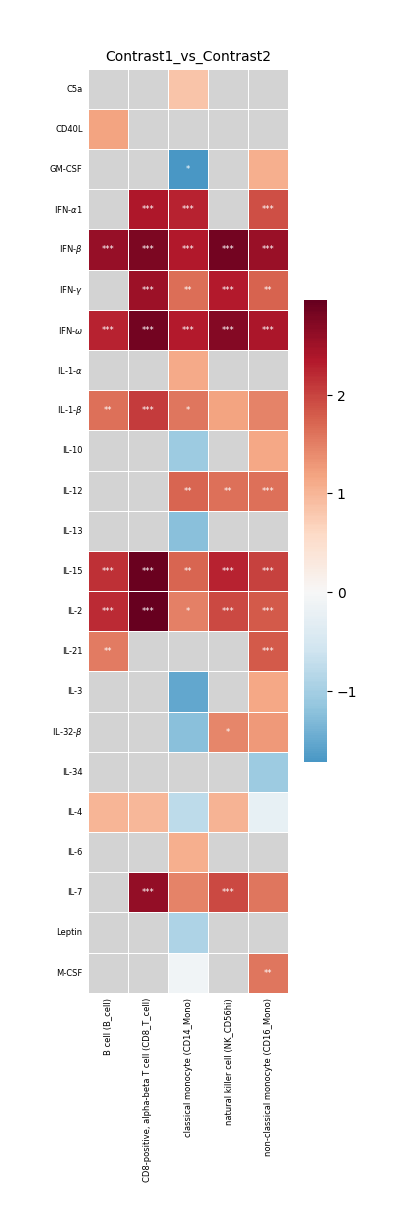

In [13]:
#### Create heatmap to visualize up-/down regulation of cytokines in all queried cell types for one contrast comparison.

robust_results_dict = hc.get_robust_significant_results(
    results=all_enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)


contrast_one = all_enrichment_results.contrast.unique()[0]  # Can be looked up manually
print(f"Contrast that was plotted in this example: {contrast_one}")

hc.plot_significant_results(
    results_pivot=robust_results_dict[contrast_one][0],
    df_annot=robust_results_dict[contrast_one][1],
    fontsize=6,
    save_fig=False,
    fig_path="",
)

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/cytokine_info.xlsx
None of the cytokine producing genes (['IFNW1']) were found in dataset for cytokine IFN-omega.
None of the cytokine producing genes (['IFNA1']) were found in dataset for cytokine IFN-alpha1.
No receptor gene found in cytokine_info for cytokine: IL-32-beta


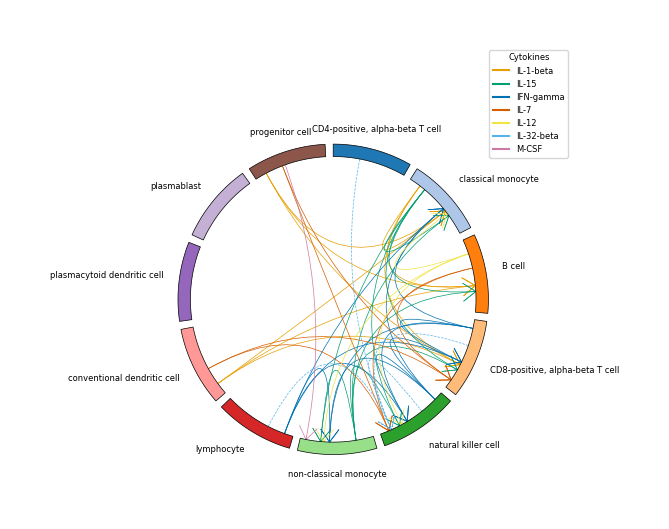

In [14]:
#### Cell-cell communication

cytokine_info = hc.load_cytokine_info()
expression_threshold = 0.1 / 10_000  # = 100 TPM
expression_threshold = np.log2((expression_threshold) + 1)

# Compute cytokine senders and receivers per cell type.
df_senders, df_receivers = hc.get_all_senders_and_receivers(
    adata=adata,
    cytokine_info=cytokine_info,
    cytokine_list=robust_results_dict[contrast_one][2].cytokine.unique(),
    celltype_colname=your_celltype_colname,
    sender_pvalue_threshold=0.1,
    receiver_mean_X_threshold=0,
)

# Plots cell-cell communication
legend_handles, legend_labels = hc.plot_communication(
    df_src=df_senders,
    df_tgt=df_receivers,
    frac_expressing_cells_sender=0,
    frac_expressing_cells_receiver=0,
    mean_cytokine_gene_expression_sender=expression_threshold,
    mean_cytokine_gene_expression_receiver=expression_threshold,
    df_enrichment=robust_results_dict[contrast_one][2],
    all_celltypes=np.array(adata.obs[your_celltype_colname].unique()),
    show_legend=True,
    figsize=(6, 7),
    lw=0.5,
    fontsize=6,
    bbox_to_anchor=(1.1, 1.1),
    loc="center",
)

In [15]:
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

Time: 16 min 3 sec


In [16]:
## --END-- ##